# Lecture 8
The **objective** of this lecture is to review and reinforce some of the manipulations that combine spatial data with clustering (dimension reduction). This is, effectively, a review and extension of **Lecture 6**. We will spend a little more time on the mundane details of data manipulation in order to identify and then surface patterns in data.  We will rely on new data on the detections of plastic waste from satellite imagery - the basis data for a [new treaty on plastic waste](https://www.nytimes.com/2022/03/02/climate/global-plastics-recycling-treaty.html) from the UN.

In [198]:
import geopandas
import matplotlib.pyplot as plt

In [199]:
# read in the data to examine the raw output
r = requests.get(
    "https://api.dev.plastic.watch.earthrise.media/sites",
    params={"limit": 1950}
)

In [200]:
# examine the response
r.json()
res = r.json()
res.keys()

dict_keys(['features', 'type'])

In [201]:
len(res["features"])

1950

### Visualize the data

In [202]:
# read it in directly to a geodataframe.  note the URL structure.
gdf = geopandas.read_file("https://api.dev.plastic.watch.earthrise.media/sites?limit=1950")

In [203]:
gdf.head()

,Distance to Waterway (m),Drainage Direction,Elevation,Fine Earth Density (kg / m^3),Height Above Nearest Drainage (m),Landform Type,Nearest Water Type,Population - 1 km,Population - 10 km,Population - 5 km,...,Soil Great Group,Soil Sand Fraction,Upstream Drainage Area (km^2),area,area (km^2),country,id,place_name,risk,geometry
0,3334.62453674793,southeast,65,142,12.10000228881836,Upper slope (flat),stream,5069,101164,36379,...,0,0.48,0.008390801027417183,0,0,India,8f6036c1dc734a0,"Ariyalur - Muttuvancheri - Sripuranthan Road, ...",None,POINT (79.17065 11.10941)
1,1591.041626719986,west,174,151,4.9000091552734375,Upper slope (flat),ditch,6025,319067,124200,...,0,0.49,0.05834398418664932,0,0,India,8f61888567309b2,"Ranipet, Wallajah, Ranipet District, Tamil Nad...",None,POINT (79.34996 12.94174)
2,729.0304416427227,northwest,38,144,0,Upper slope (flat),canal,4313,104904,30300,...,0,0.41,0.2697521448135376,0,0,India,8f603485355d70b,"Ilaiyankudi, Ilayangudi, Sivagangai District, ...",None,POINT (78.61907 9.63222)
3,1084.194172414804,northeast,41,136,20.700002670288086,Upper slope (warm),river,1694,86171,32947,...,0,0.64,0.008489136584103107,438.87868333256085,0.00043887868333256086,Indonesia,8f8d8141b6e96ce,"Latsari, Bancar, Tuban, East Java, 62354, Indo...",0.5269615152831083,POINT (111.70668 -6.78753)
4,-1,southeast,120,113,6.3000030517578125,Lower slope (warm),-1,131,143061,13771,...,1,0.45,0.008327875286340714,907.8331830324696,0.0009078331830324696,Cambodia,8f659db0b6d3948,"Nong Ta Khong, Chanthaburi Province, Thailand",<nil>,POINT (102.39368 13.15480)


<AxesSubplot:>

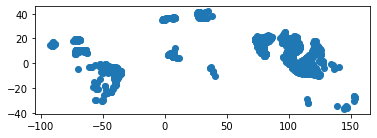

In [204]:
# Plot the raw output
gdf.plot()

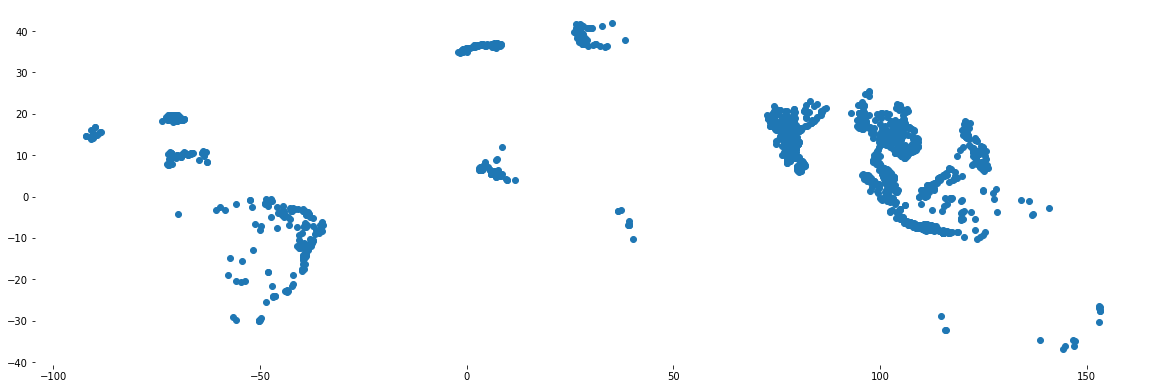

In [206]:
# plot it again but setting it up for more complicated graphics
fig, ax = plt.subplots(figsize=(20,10))

gdf.plot(
    ax=ax
)

plt.box(on=None) 

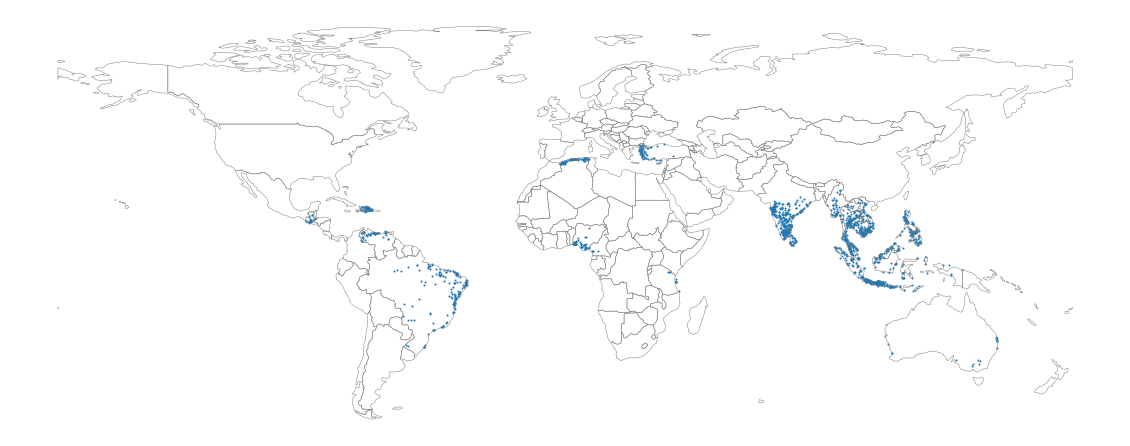

In [207]:
# add the political boundaries
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != "Antarctica"]

fig, ax = plt.subplots(figsize=(20,10))

world.boundary.plot(
    ax=ax,
    color="grey",
    linewidth=0.5
)

gdf.plot(
    ax=ax,
    markersize=1
)

# we don't need to see the latitude and longitude for the global map
# we have all the context we need
ax.set_axis_off()

### Aggregate the number of sites by country 

In [208]:
# could be done by stringing methods. but check each stage.
count_df = gdf.groupby("country")["country"].count()
count_df = count_df.to_frame()
count_df = count_df.rename(columns={'country':'ct'})
count_df = count_df.reset_index()
count_df

,country,ct
0,Algeria,74
1,Australia,16
2,Brazil,157
3,Brunei,4
4,Cambodia,39
5,Cameroon,4
6,Dominican Republic,64
7,Guatemala,20
8,Haiti,8
9,India,362


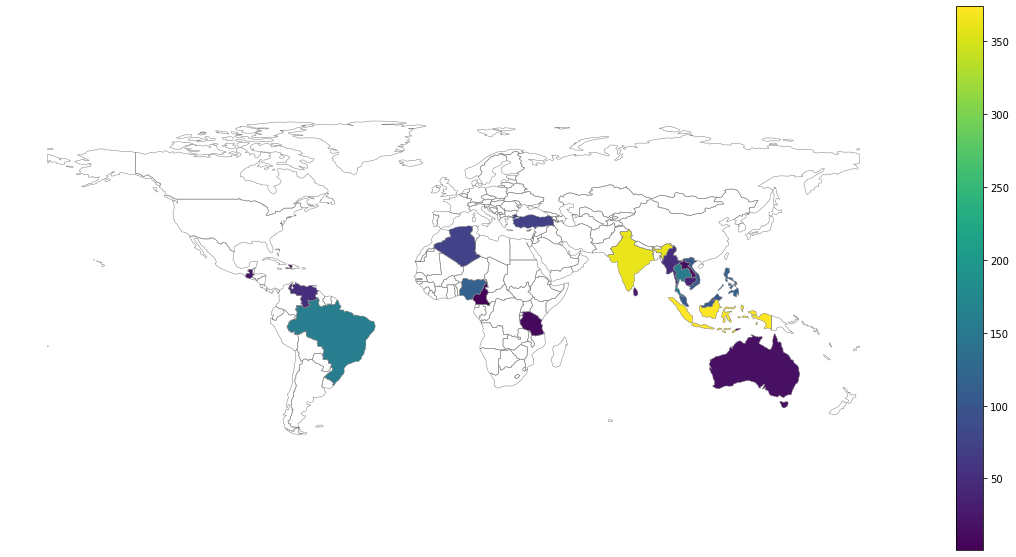

In [210]:
# merge in and then plot the country counts
subset_df = world.merge(count_df, left_on="name", right_on="country", how="right")
subset_df = subset_df.dropna()

fig, ax = plt.subplots(figsize=(20,10))

world.boundary.plot(
    ax=ax,
    color="grey",
    linewidth=0.5
)

subset_df.plot(
    ax=ax,
    column="ct",
    legend=True
)

ax.set_axis_off()

### Clustering sites
We can rely on the computer to surface similar sites based on their physical characteristics.  

In [211]:
X = gdf[[
    "Distance to Waterway (m)",
    "Elevation",
    "Population - 1 km",
    "Fine Earth Density (kg / m^3)",
    "Soil Sand Fraction",
    "area"
]]
X = X.values

In [212]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

The matrix must be standardized for this to work.  Recall that, before, we just had a binary matrix, rather than a matrix of continuous values.  First, we import the `StandardScaler()` class. Then, we create an object of that class and store it in the variable scaler. Then we use the scaler object’s `fit()` method with the input `X` (feature matrix). This will calculate the mean and standard deviation for each variable in the dataset. Finally, we do the transformation with the `transform()` method of the scaler object. The transformed (scaled) values of `X` are stored in the variable `X_scaled`.

In [213]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

(0.0, 19500.0, 0.0, 65.90398059415354)

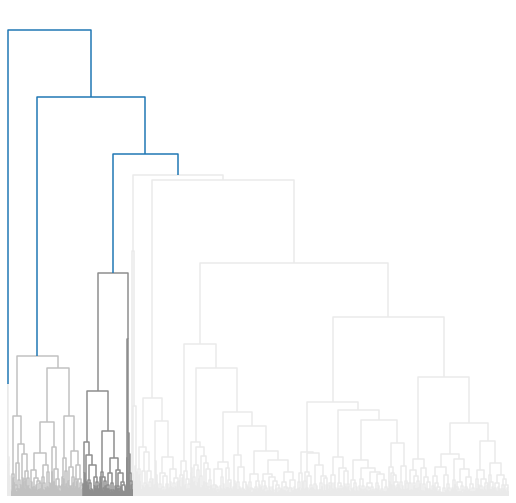

In [214]:
import scipy.cluster.hierarchy as shc
fig, ax = plt.subplots(figsize=(9,9))

# set a color palette based on hex color codes, repeating triplets
# NOTE: this sets a global variable, so try it first without applying these 
# colors so you can see how ugly it is
shc.set_link_color_palette(["#EAEAEA", "#C1C1C1", "#8E8E8E"])

# The distance metric between clusters `complete` is defined by the furthest 
# points between two clusters. Another way to calculate the distance leverates 
# the Ward method. Others worth exploring are: median, average.
dend = shc.dendrogram(
    shc.linkage(X_scaled, method="ward"),
    ax=ax
)

plt.box(on=None) 
plt.axis('off')

In [215]:
# the distance between points is given by `euclidean` while the clusters 
# are defined by minimizing variance using the Ward method.
cluster = AgglomerativeClustering(
    n_clusters=8, 
    affinity='euclidean', 
    linkage='ward'
)

# assign a new column based on the label and print the values in the new column
gdf["label"] = cluster.fit_predict(X_scaled)

# what are the different labels?
set(gdf["label"])

{0, 1, 2, 3, 4, 5, 6, 7}

<AxesSubplot:>

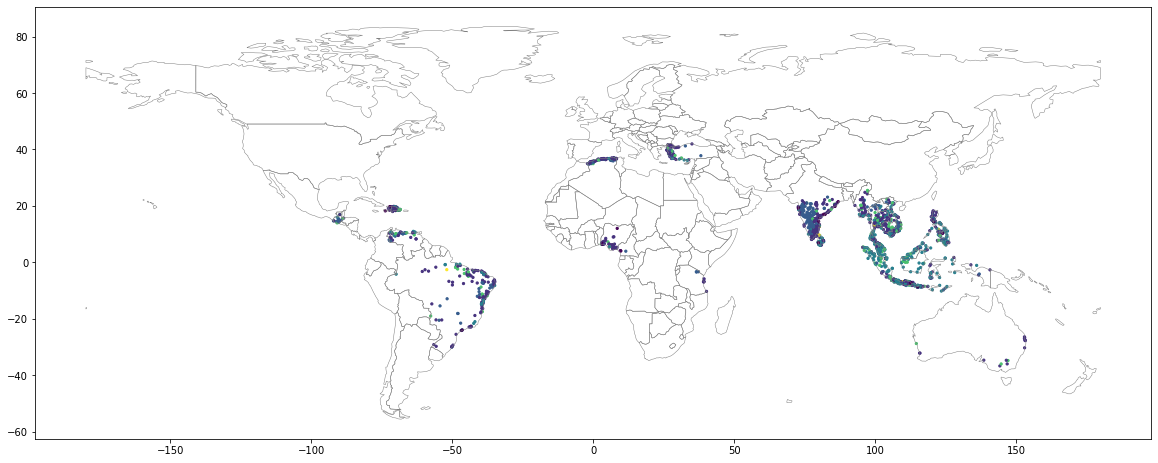

In [216]:
fig, ax = plt.subplots(figsize=(20,10))

world.boundary.plot(
    ax=ax,
    color="grey",
    linewidth=0.5
)

gdf.plot(
    ax=ax,
    markersize=5,
    column="label"
)

# we don't need to see the latitude and longitude for the global map
# we have all the context we need
# ax.set_axis_off()

<AxesSubplot:>

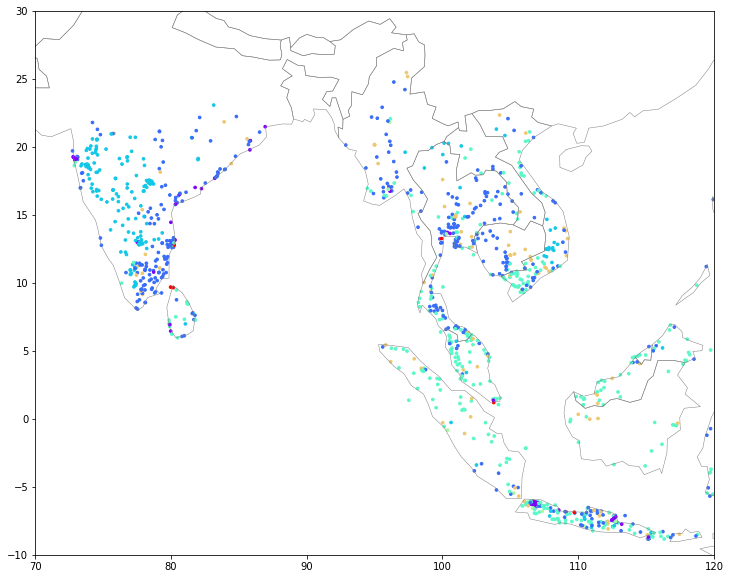

In [217]:
# zoom in for detail
# Note the distinct regions
# Recall that there was no explicit spatial information in the feature matrix
# What are some of the reasons for 
fig, ax = plt.subplots(figsize=(20,10))

ax.set_xlim([70, 120])
ax.set_ylim([-10, 30])

world.boundary.plot(
    ax=ax,
    color="grey",
    linewidth=0.5
)

gdf.plot(
    ax=ax,
    markersize=7,
    column="label",
    cmap="rainbow"
)
